In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def euler(time_steps, y0, system, params=None):
    ys = [y0]
    for i in range(len(time_steps)-1):
        h = time_steps[i+1] - time_steps[i]
        t = time_steps[i]
        y_next = ys[-1] + h * system(t, ys[-1], params)
        ys.append(y_next)
    return np.array(ys)

In [4]:
def runge_kutta(time_steps, y0, system, params=None):
    ys = [y0]
    for i in range(len(time_steps)-1):
        h = time_steps[i+1] - time_steps[i]
        t = time_steps[i]
        k1 = system(t, ys[-1], params)
        k2 = system(t + h/2, ys[-1] + (h/2)*k1, params)
        k3 = system(t + h/2, ys[-1] + (h/2)*k2, params)
        k4 = system(t + h, ys[-1] + h*k3, params)
        y_next = ys[-1] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
        ys.append(y_next)
    return np.array(ys)

In [5]:
def robust_solver(F, residual, eps=1e-10):
    U, s, Vh = np.linalg.svd(F, full_matrices=False)
    s_inv = np.zeros_like(s)
    mask = s > eps * np.max(s)
    s_inv[mask] = 1 / s[mask]
    dy = Vh.T @ (s_inv * (U.T @ residual))
    rank = np.sum(mask)
    if rank < len(s):
        print(f"Warning: Rank deficiency (rank={rank}, cond_number={s[0]/s[-1]:.1e})")
    return dy

In [6]:
def shooting(time_steps, y_approx, system, params, bc, bc_params,
            solver=runge_kutta, eps=1e-4, max_iter=100, svd_threshold=1e-8):
    y_approx = np.asarray(y_approx, dtype=np.float64).copy()
    t_mid = len(time_steps) // 2
    t_left = time_steps[t_mid::-1]
    t_right = time_steps[t_mid:]
    F = np.zeros((len(y_approx), len(y_approx)), dtype=np.float64)
    residuals = []

    for newton_steps in range(max_iter):
        ys_left = solver(t_left, y_approx, system, params)[::-1]
        ys_right = solver(t_right, y_approx, system, params)[1:]
        ys = np.concatenate((ys_left, ys_right))

        residual = bc(ys, bc_params)
        residual_norm = np.linalg.norm(residual)
        residuals.append(residual_norm)

        if residual_norm < eps:
            break

        perturb_eps = max(eps, 1e-6 * residual_norm)
        for i in range(len(y_approx)):
            y_perturbed = y_approx.copy()
            y_perturbed[i] += perturb_eps
            ys_perturbed = np.concatenate((
                solver(t_left, y_perturbed, system, params)[::-1],
                solver(t_right, y_perturbed, system, params)[1:]
            ))
            residual_perturbed = bc(ys_perturbed, bc_params)
            F[:, i] = (residual_perturbed - residual) / perturb_eps

        U, s, Vh = np.linalg.svd(F, full_matrices=False)
        rank = np.sum(s > svd_threshold * s[0])

        if rank < len(y_approx):
            print(f"Warning: Rank deficiency (rank={rank}, cond_number={s[0]/s[-1]:.1e})")

        s_inv = np.zeros_like(s)
        s_inv[s > svd_threshold * s[0]] = 1 / s[s > svd_threshold * s[0]]
        dy = Vh.T @ (s_inv * (U.T @ residual))

        step_norm = np.linalg.norm(dy)
        if step_norm > 1.0:
            dy = dy / (step_norm * 2)
        y_approx = y_approx - dy.astype(np.float64)

    return {
        "solution": ys,
        "frechet_matrix": F,
        "singular_values": s,
        "residuals": residuals,
        "final_residual": residuals[-1],
        "rank": rank
    }

Матрица Фреше для R_systemic = 0.50:
[[ 0.6406 -0.1141 -0.0075]
 [ 0.8585 -0.3785 -0.018 ]
 [-2.8713  2.5385  1.0552]]
Определитель: -1.3724e-01
Матрица Фреше для R_systemic = 0.89:
[[ 0.6667  0.043  -0.0028]
 [ 0.7471 -0.0632 -0.0043]
 [-1.8865  1.6192  1.0106]]
Определитель: -7.3184e-02
Матрица Фреше для R_systemic = 1.28:
[[ 7.0440e-01  8.4300e-02  6.0000e-04]
 [ 7.0180e-01  7.7800e-02  2.2000e-03]
 [-1.5382e+00  1.3141e+00  9.9620e-01]]
Определитель: -6.0774e-03
Матрица Фреше для R_systemic = 1.67:
[[ -2.4554   5.5058  -0.7601]
 [ 27.7236 -45.5659   6.4142]
 [-41.7434  69.4137  -8.568 ]]
Определитель: -4.8704e+01
Матрица Фреше для R_systemic = 2.06:
[[ 0.7744  0.0854  0.0016]
 [ 0.7485  0.1238 -0.004 ]
 [-1.4381  1.2683  1.006 ]]
Определитель: 3.8364e-02
Матрица Фреше для R_systemic = 2.44:
[[-140825.5914   16291.7513    7821.6055]
 [-136121.4059   24558.429    13064.4055]
 [ 203183.3444  -36283.1309  -19565.3391]]
Определитель: 3.7028e+11
Матрица Фреше для R_systemic = 2.83:
[[ -5

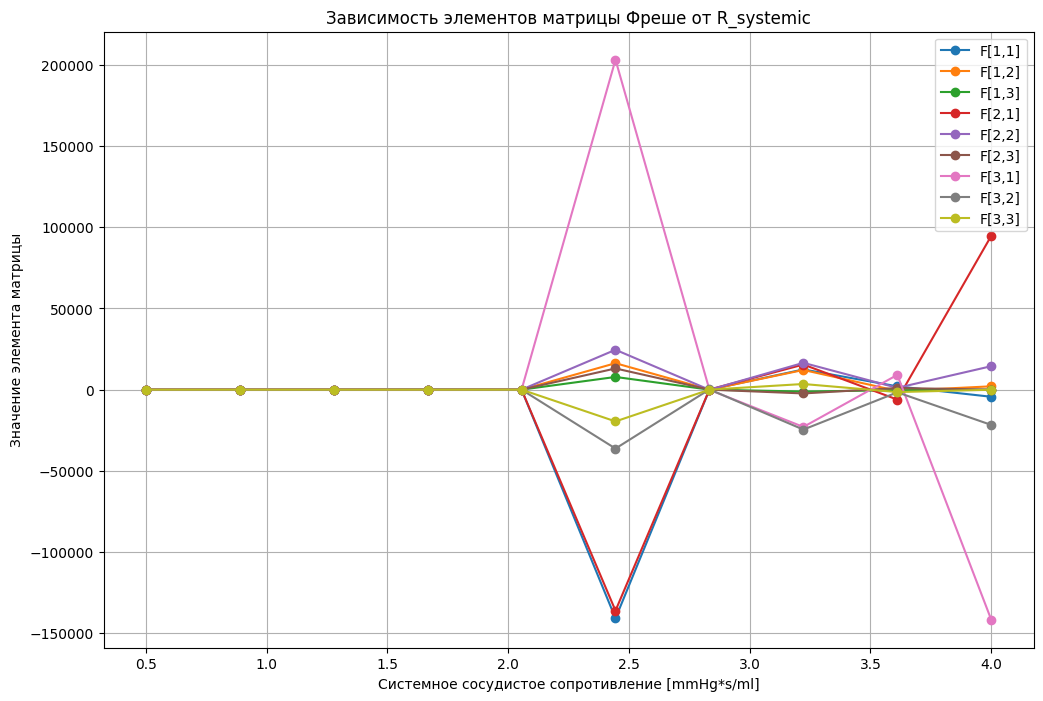

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

base_params = {
    'R_systemic': 1.0,
    'C_systemic': 1.5,
    'R_valve': 0.01,
    'E_max': 2.5,
    'E_min': 0.07,
    'T_cycle': 0.8
}

def cardiac_system(t, y, params):
    P_lv, P_aorta, V_lv = y
    t_cycle = params['T_cycle']
    E_t = params['E_min'] + (params['E_max']-params['E_min'])*np.sin(np.pi*(t%t_cycle)/t_cycle)**2

    Q_valve = max(0, (P_lv - P_aorta)/params['R_valve'])
    Q_systemic = P_aorta/params['R_systemic']

    return [
        E_t * (-Q_valve),
        (Q_valve - Q_systemic)/params['C_systemic'],
        -Q_valve
    ]


def compute_Frechet(param_name, param_value):
    params = base_params.copy()
    params[param_name] = param_value
    t_span = [0, params['T_cycle']]
    t_eval = np.linspace(0, params['T_cycle'], 100)
    y0 = [100, 80, 150]

    sol = solve_ivp(cardiac_system, t_span, y0, args=(params,), t_eval=t_eval)
    eps = 1e-6
    F = np.zeros((3,3))

    for i in range(3):
        y_perturbed = y0.copy()
        y_perturbed[i] += eps

        sol_perturbed = solve_ivp(cardiac_system, t_span, y_perturbed, args=(params,), t_eval=t_eval)
        F[:,i] = ((sol_perturbed.y[:,-1] - sol.y[:,-1])/eps).flatten()

    return F

R_values = np.linspace(0.5, 4.0, 10)
F_matrices = []

for R in R_values:
    F = compute_Frechet('R_systemic', R)
    F_matrices.append(F)
    print(f"Матрица Фреше для R_systemic = {R:.2f}:")
    print(np.round(F, 4))
    print(f"Определитель: {np.linalg.det(F):.4e}")

plt.figure(figsize=(12,8))
for i in range(3):
    for j in range(3):
        plt.plot(R_values, [F[i,j] for F in F_matrices], 'o-',
                label=f'F[{i+1},{j+1}]')

plt.title('Зависимость элементов матрицы Фреше от R_systemic')
plt.xlabel('Системное сосудистое сопротивление [mmHg*s/ml]')
plt.ylabel('Значение элемента матрицы')
plt.legend()
plt.grid(True)
plt.show()


Матрица Фреше для C_systemic = 0.50:
[[ 1.95220e+00 -1.67880e+00 -2.34000e-02]
 [-3.35585e+01  4.15892e+01  5.64100e-01]
 [ 1.57361e+01 -1.97671e+01  7.26000e-01]]
Определитель: 2.4700e+01

Матрица Фреше для C_systemic = 0.89:
[[ 0.4129  0.2776  0.0108]
 [ 3.0456 -2.7525 -0.1261]
 [-3.3137  3.2921  1.1114]]
Определитель: -1.9055e+00

Матрица Фреше для C_systemic = 1.28:
[[ 6.5210e-01  6.4100e-02 -0.0000e+00]
 [ 6.4580e-01  6.4200e-02 -1.0000e-04]
 [-1.4320e+00  1.1251e+00  1.0004e+00]]
Определитель: 5.2900e-04

Матрица Фреше для C_systemic = 1.67:
[[ 0.6987  0.0526 -0.0029]
 [ 0.7032  0.0391 -0.003 ]
 [-1.8222  1.5655  1.0082]]
Определитель: -9.5753e-03

Матрица Фреше для C_systemic = 2.06:
[[ 1.1768 -0.4667 -0.0285]
 [-0.8863  1.9226  0.0685]
 [ 1.1148 -1.8846  0.8691]]
Определитель: 1.7368e+00

Матрица Фреше для C_systemic = 2.44:
[[ 6.5660e-01  1.5140e-01  1.0000e-04]
 [ 6.5030e-01  1.5110e-01  2.0000e-04]
 [-2.1574e+00  1.9254e+00  9.9940e-01]]
Определитель: 4.7470e-04

Матрица Фр

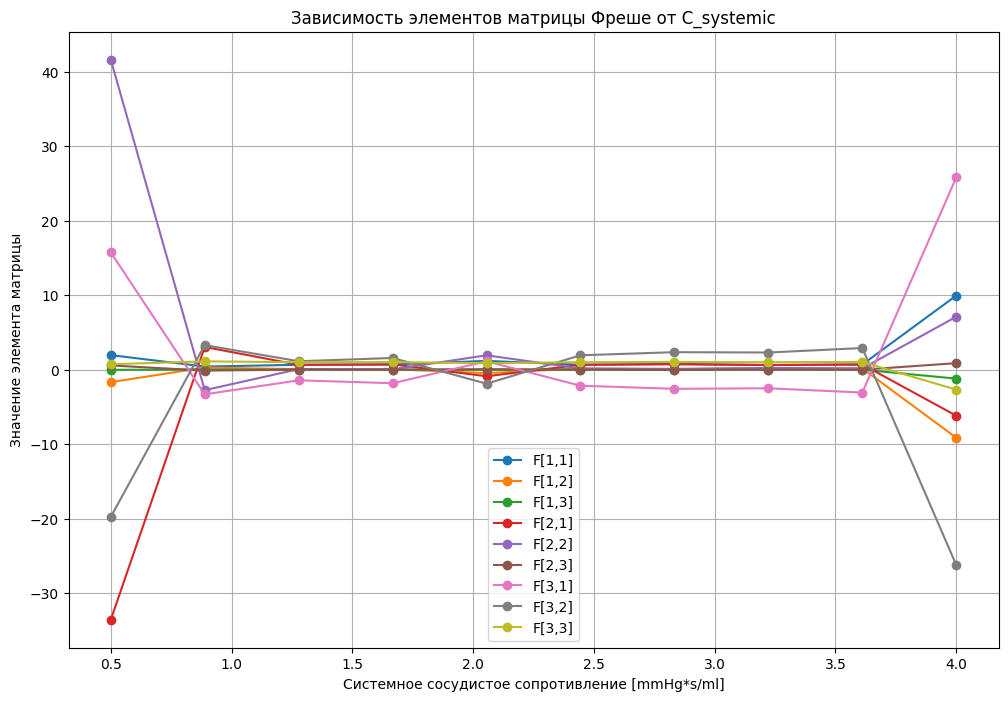

In [9]:
R_values = np.linspace(0.5, 4.0, 10)
F_matrices = []

for R in R_values:
    F = compute_Frechet('C_systemic', R)
    F_matrices.append(F)
    print(f"Матрица Фреше для C_systemic = {R:.2f}:")
    print(np.round(F, 4))
    print(f"Определитель: {np.linalg.det(F):.4e}")

plt.figure(figsize=(12,8))
for i in range(3):
    for j in range(3):
        plt.plot(R_values, [F[i,j] for F in F_matrices], 'o-',
                label=f'F[{i+1},{j+1}]')

plt.title('Зависимость элементов матрицы Фреше от C_systemic')
plt.xlabel('Системное сосудистое сопротивление [mmHg*s/ml]')
plt.ylabel('Значение элемента матрицы')
plt.legend()
plt.grid(True)
plt.show()

Матрица Фреше для R_valve = 0.01:
[[ 6.4870e-01  9.2800e-02  5.0000e-04]
 [ 6.4370e-01  9.1400e-02  3.0000e-04]
 [-1.5542e+00  1.2625e+00  9.9880e-01]]
Определитель: -2.9258e-04
Матрица Фреше для R_valve = 0.45:
[[ 3.6040e-01  4.3500e-01  1.2000e-03]
 [ 2.8690e-01  3.8000e-01 -4.0000e-04]
 [-6.2920e-01  4.7850e-01  1.0007e+00]]
Определитель: 1.2829e-02
Матрица Фреше для R_valve = 0.90:
[[ 0.454   0.3917  0.    ]
 [ 0.2219  0.4259  0.    ]
 [-0.4636  0.3509  1.    ]]
Определитель: 1.0645e-01
Матрица Фреше для R_valve = 1.34:
[[ 5.522e-01  3.239e-01 -1.000e-04]
 [ 1.829e-01  4.521e-01 -0.000e+00]
 [-3.739e-01  2.859e-01  1.000e+00]]
Определитель: 1.9041e-01
Матрица Фреше для R_valve = 1.78:
[[ 6.144e-01  2.862e-01 -1.000e-04]
 [ 1.535e-01  4.736e-01 -0.000e+00]
 [-3.101e-01  2.370e-01  1.000e+00]]
Определитель: 2.4703e-01
Матрица Фреше для R_valve = 2.23:
[[ 6.649e-01  2.523e-01 -1.000e-04]
 [ 1.324e-01  4.887e-01 -0.000e+00]
 [-2.653e-01  2.032e-01  1.000e+00]]
Определитель: 2.9153e-01


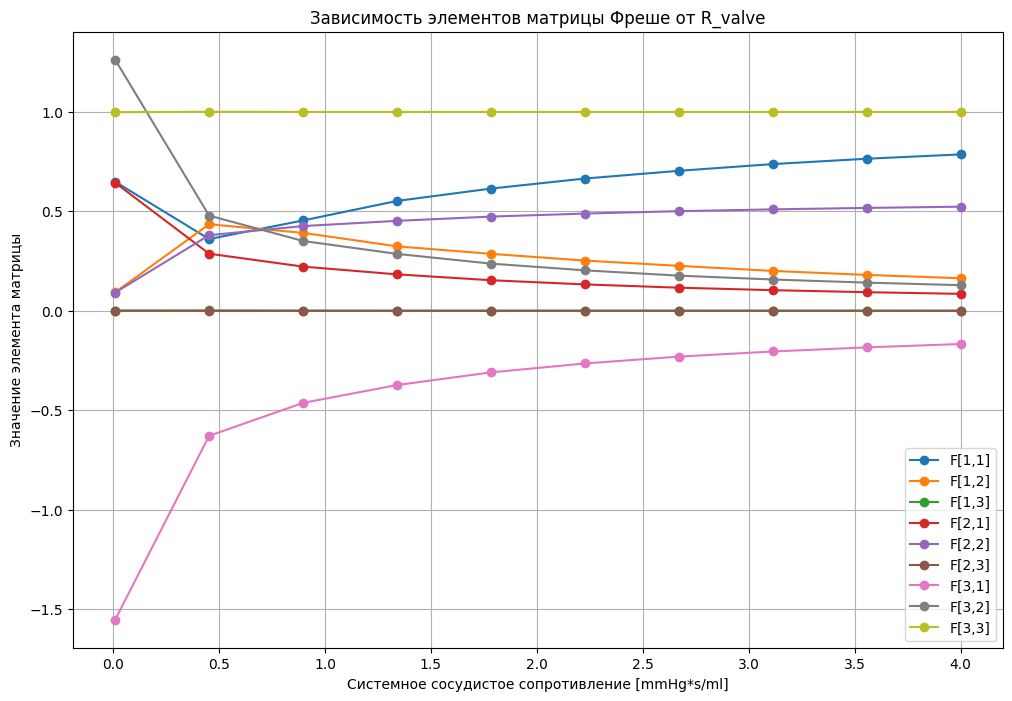

In [10]:
R_values = np.linspace(0.01, 4.0, 10)
F_matrices = []

for R in R_values:
    F = compute_Frechet('R_valve', R)
    F_matrices.append(F)
    print(f"Матрица Фреше для R_valve = {R:.2f}:")
    print(np.round(F, 4))
    print(f"Определитель: {np.linalg.det(F):.4e}")

plt.figure(figsize=(12,8))
for i in range(3):
    for j in range(3):
        plt.plot(R_values, [F[i,j] for F in F_matrices], 'o-',
                label=f'F[{i+1},{j+1}]')

plt.title('Зависимость элементов матрицы Фреше от R_valve')
plt.xlabel('Системное сосудистое сопротивление [mmHg*s/ml]')
plt.ylabel('Значение элемента матрицы')
plt.legend()
plt.grid(True)
plt.show()


Матрица Фреше для E_max = 0.10:
[[ 0.9436 -0.0099 -0.0071]
 [-0.2202  1.2738  0.0789]
 [-0.4694 -0.3641  0.8888]]
Определитель: 1.0891e+00

Матрица Фреше для E_max = 0.53:
[[ 0.8223  0.0137  0.0055]
 [ 0.4682  0.5561 -0.056 ]
 [-1.3846  0.6187  1.0856]]
Определитель: 5.2483e-01

Матрица Фреше для E_max = 0.97:
[[ 7.6930e-01  3.5900e-02 -1.2000e-03]
 [ 7.4390e-01  6.2800e-02 -3.6000e-03]
 [-1.7905e+00  1.3699e+00  1.0079e+00]]
Определитель: 2.4401e-02

Матрица Фреше для E_max = 1.40:
[[ 0.671   0.1334 -0.0069]
 [ 1.4055 -0.8879  0.0426]
 [-2.7682  2.7937  0.9379]]
Определитель: -8.4046e-01

Матрица Фреше для E_max = 1.83:
[[ 0.7227  0.0351 -0.0036]
 [ 0.6874  0.0697 -0.0029]
 [-1.6981  1.3751  1.0069]]
Определитель: 2.5575e-02

Матрица Фреше для E_max = 2.27:
[[ 0.609   0.1443  0.004 ]
 [ 0.9752 -0.2562 -0.0304]
 [-2.0374  1.7639  1.0442]]
Определитель: -2.6351e-01

Матрица Фреше для E_max = 2.70:
[[ 0.6066  0.1095  0.017 ]
 [ 1.0073 -0.0506 -0.1724]
 [-2.0964  1.4746  1.2578]]
Определ

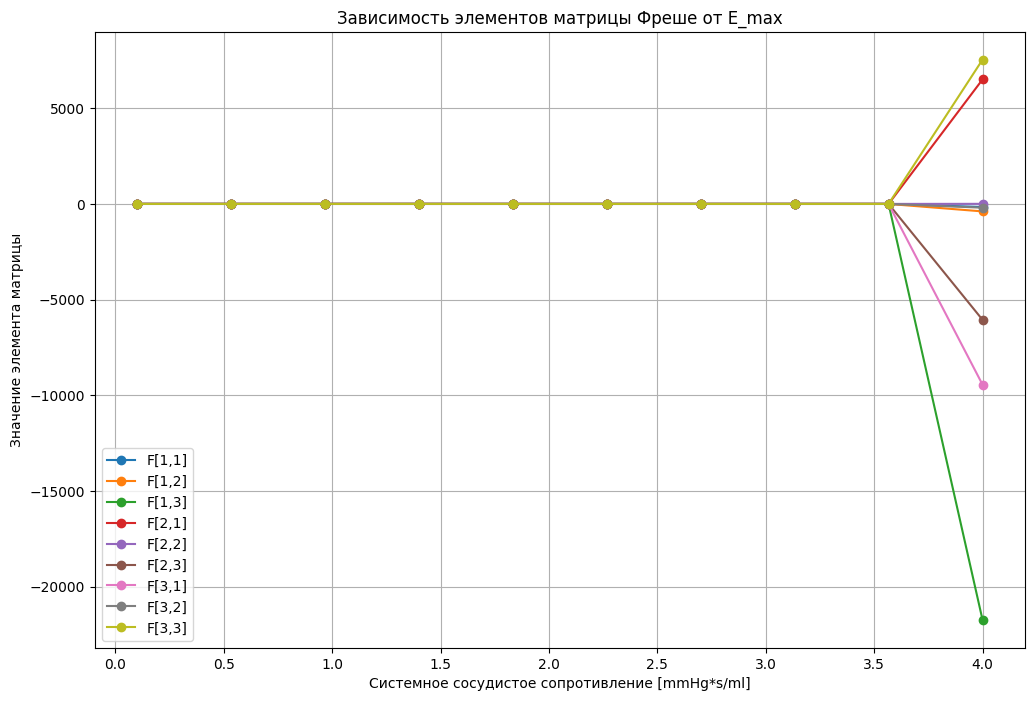

In [11]:
R_values = np.linspace(0.1, 4.0, 10)
F_matrices = []

for R in R_values:
    F = compute_Frechet('E_max', R)
    F_matrices.append(F)
    print(f"\nМатрица Фреше для E_max = {R:.2f}:")
    print(np.round(F, 4))
    print(f"Определитель: {np.linalg.det(F):.4e}")

plt.figure(figsize=(12,8))
for i in range(3):
    for j in range(3):
        plt.plot(R_values, [F[i,j] for F in F_matrices], 'o-',
                label=f'F[{i+1},{j+1}]')

plt.title('Зависимость элементов матрицы Фреше от E_max')
plt.xlabel('Системное сосудистое сопротивление [mmHg*s/ml]')
plt.ylabel('Значение элемента матрицы')
plt.legend()
plt.grid(True)
plt.show()


Матрица Фреше для E_min = 0.10:
[[ -5.8783   8.5657  -0.1703]
 [ 43.9502 -56.2041   1.1329]
 [-65.9275  84.9499  -0.6843]]
Определитель: -4.7306e+01

Матрица Фреше для E_min = 0.53:
[[ 0.7885 -0.1167 -0.0352]
 [-0.2648  1.0215  0.0579]
 [ 0.0033 -0.3102  0.9155]]
Определитель: 7.2049e-01

Матрица Фреше для E_min = 0.97:
[[ 29.0226 -33.2881  -1.3005]
 [-19.6906  23.817    0.9036]
 [ 29.1785 -34.5192  -0.3515]]
Определитель: 3.4845e+01

Матрица Фреше для E_min = 1.40:
[[ 0.2142  0.466  -0.002 ]
 [ 0.2189  0.4527  0.001 ]
 [-0.5393  0.3699  0.9983]]
Определитель: -5.9952e-03

Матрица Фреше для E_min = 1.83:
[[ 1.825e-01  4.844e-01 -7.000e-04]
 [ 1.763e-01  4.890e-01  3.000e-04]
 [-4.423e-01  2.862e-01  9.993e-01]]
Определитель: 3.6127e-03

Матрица Фреше для E_min = 2.27:
[[ 1.9100e-01  4.5530e-01  1.3000e-03]
 [ 1.3480e-01  5.2770e-01 -5.0000e-04]
 [-3.5990e-01  2.1060e-01  1.0004e+00]]
Определитель: 3.9806e-02

Матрица Фреше для E_min = 2.70:
[[-7.68291420e+04 -1.45664530e+05 -7.2703000

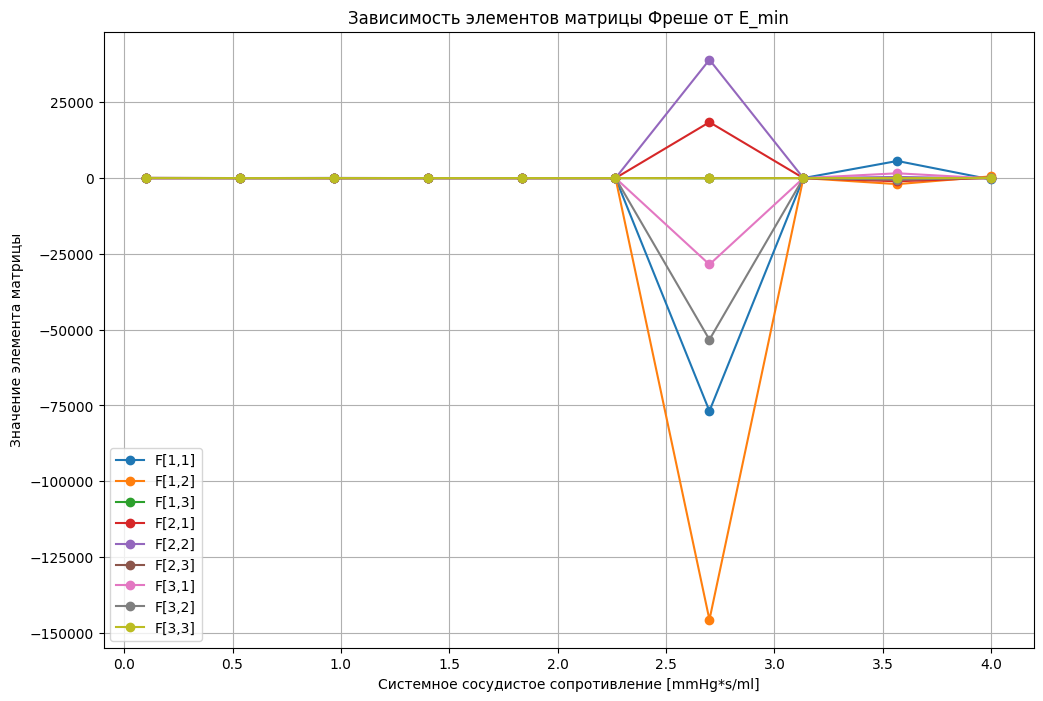

In [12]:
R_values = np.linspace(0.1, 4.0, 10)
F_matrices = []

for R in R_values:
    F = compute_Frechet('E_min', R)
    F_matrices.append(F)
    print(f"\nМатрица Фреше для E_min = {R:.2f}:")
    print(np.round(F, 4))
    print(f"Определитель: {np.linalg.det(F):.4e}")

plt.figure(figsize=(12,8))
for i in range(3):
    for j in range(3):
        plt.plot(R_values, [F[i,j] for F in F_matrices], 'o-',
                label=f'F[{i+1},{j+1}]')

plt.title('Зависимость элементов матрицы Фреше от E_min')
plt.xlabel('Системное сосудистое сопротивление [mmHg*s/ml]')
plt.ylabel('Значение элемента матрицы')
plt.legend()
plt.grid(True)
plt.show()


Матрица Фреше для T_cycle = 0.10:
[[ 6.492e-01  3.181e-01  6.000e-04]
 [ 6.479e-01  3.116e-01  3.000e-04]
 [-1.032e+00  9.948e-01  9.995e-01]]
Определитель: -3.5317e-03

Матрица Фреше для T_cycle = 0.53:
[[ 7.0450e-01  1.1710e-01 -3.0000e-04]
 [ 6.9860e-01  1.1570e-01 -3.0000e-04]
 [-1.4655e+00  1.2659e+00  1.0001e+00]]
Определитель: -3.1840e-04

Матрица Фреше для T_cycle = 0.97:
[[ 0.6583  0.0317 -0.0021]
 [ 0.7626 -0.104  -0.003 ]
 [-1.9197  1.6356  1.0075]]
Определитель: -9.2112e-02

Матрица Фреше для T_cycle = 1.40:
[[ 5.3890e-01  5.2800e-02 -1.4000e-03]
 [ 7.8920e-01 -2.6700e-01 -6.0000e-04]
 [-2.2413e+00  1.8893e+00  1.0035e+00]]
Определитель: -1.8677e-01

Матрица Фреше для T_cycle = 1.83:
[[  3.8847  -5.6607   0.4224]
 [-36.1886  61.3206  -4.5333]
 [ 52.4908 -89.6301   7.7317]]
Определитель: 3.6975e+01

Матрица Фреше для T_cycle = 2.27:
[[ 3.9010e-01  3.7200e-02 -8.0000e-04]
 [ 2.9160e-01  1.3670e-01  9.4000e-03]
 [-1.8012e+00  1.1223e+00  9.8570e-01]]
Определитель: 3.6693e-02


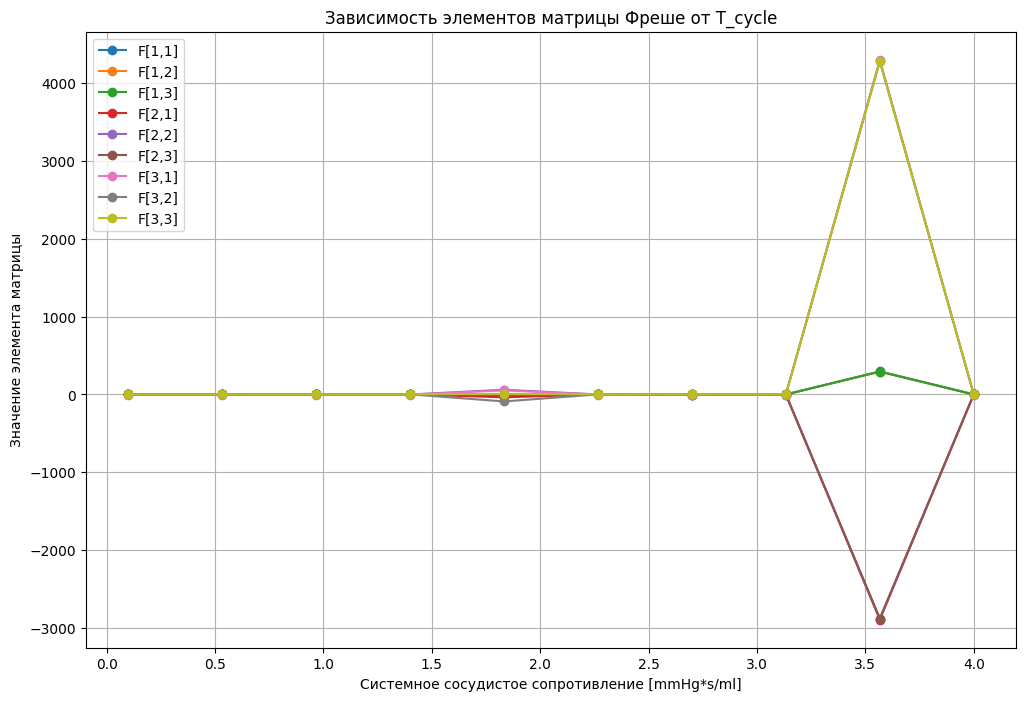

In [13]:
R_values = np.linspace(0.1, 4.0, 10)
F_matrices = []

for R in R_values:
    F = compute_Frechet('T_cycle', R)
    F_matrices.append(F)
    print(f"\nМатрица Фреше для T_cycle = {R:.2f}:")
    print(np.round(F, 4))
    print(f"Определитель: {np.linalg.det(F):.4e}")

plt.figure(figsize=(12,8))
for i in range(3):
    for j in range(3):
        plt.plot(R_values, [F[i,j] for F in F_matrices], 'o-',
                label=f'F[{i+1},{j+1}]')

plt.title('Зависимость элементов матрицы Фреше от T_cycle')
plt.xlabel('Системное сосудистое сопротивление [mmHg*s/ml]')
plt.ylabel('Значение элемента матрицы')
plt.legend()
plt.grid(True)
plt.show()